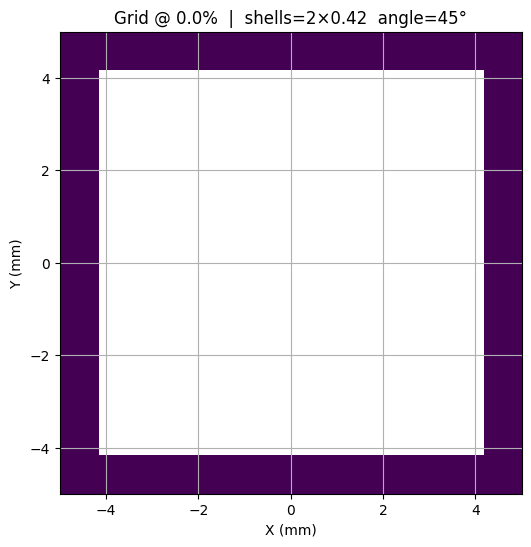

==== Grid Infill 0.0% ====
Total Area            = 31.1879 mm²
Shell Area            = 31.1879 mm²
Infill Area           = 0.0000 mm²
I_x                   = 440.0430
I_y                   = 440.0430
I_xy                  = -0.0000
Polar moment, J       = 880.0860



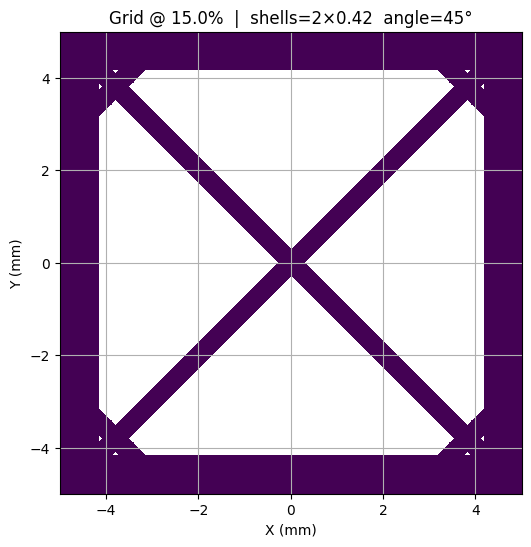

==== Grid Infill 15.0% ====
Total Area            = 41.5764 mm²
Shell Area            = 31.1879 mm²
Infill Area           = 10.3885 mm²
I_x                   = 507.1439
I_y                   = 507.1439
I_xy                  = -0.0000
Polar moment, J       = 1014.2879



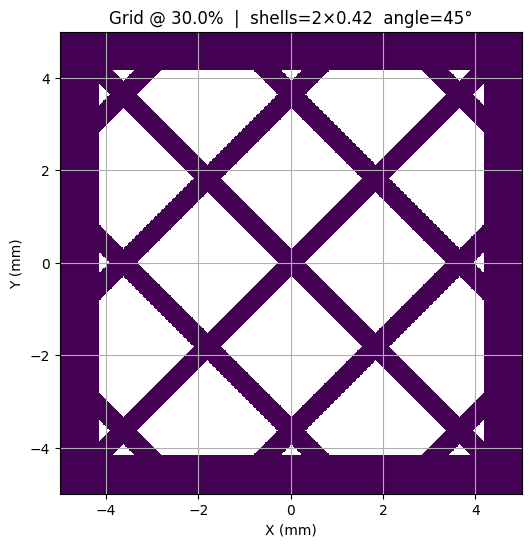

==== Grid Infill 30.0% ====
Total Area            = 52.1754 mm²
Shell Area            = 31.1879 mm²
Infill Area           = 20.9874 mm²
I_x                   = 567.1050
I_y                   = 567.1050
I_xy                  = 0.0000
Polar moment, J       = 1134.2101



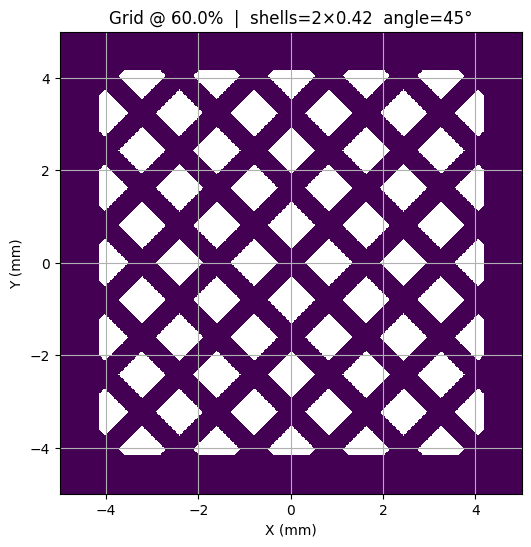

==== Grid Infill 60.0% ====
Total Area            = 71.9147 mm²
Shell Area            = 31.1879 mm²
Infill Area           = 40.7268 mm²
I_x                   = 671.7147
I_y                   = 671.7147
I_xy                  = -0.0000
Polar moment, J       = 1343.4294



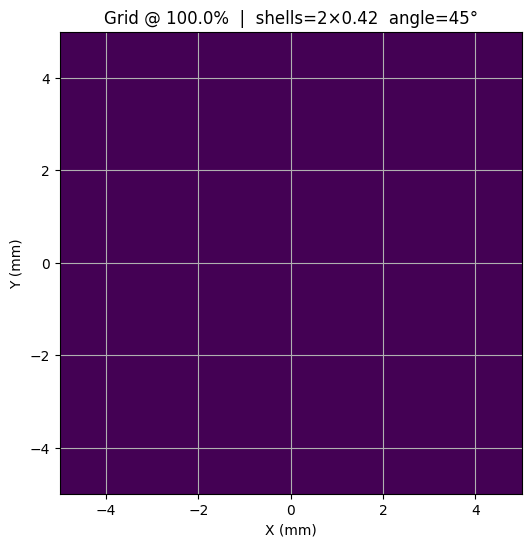

==== Grid Infill 100.0% ====
Total Area            = 100.2505 mm²
Shell Area            = 31.1879 mm²
Infill Area           = 69.0625 mm²
I_x                   = 837.5117
I_y                   = 837.5117
I_xy                  = -0.0000
Polar moment, J       = 1675.0235



In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Geometry utilities
# ------------------------------

def _dist_mod(u, spacing):
    """Distance to nearest line center in a periodic family with pitch=spacing."""
    r = np.mod(u, spacing)
    return np.minimum(r, spacing - r)

def _rectilinear_mask(XX, YY, spacing, line_width, angle_deg=0.0, phase=0.0):
    """
    Rectilinear (parallel lines) mask at angle_deg, with true line width.
    Lines are centered where (x cos + y sin + phase) is a multiple of spacing.
    """
    th = np.deg2rad(angle_deg)
    # Coordinate along the line-normal direction (u-axis)
    u =  XX * np.cos(th) + YY * np.sin(th)
    dist = _dist_mod(u + phase, spacing)
    # Render a line of width 'line_width' around the center => half width threshold
    return dist <= (line_width / 2.0)

def _spacing_for_grid_density(line_width, f):
    """
    For a two-axis grid (two orthogonal families of rectilinear lines with true width 'w'),
    the area fraction is f = 2r - r^2 where r = w/s.
    Solve for s: r = 1 - sqrt(1 - f)  =>  s = w / r.
    """
    f = float(np.clip(f, 0.0, 1.0))
    if f <= 0.0:
        return np.inf
    if f >= 1.0:
        return line_width  # centers are one line_width apart for a "solid" raster
    r = 1.0 - np.sqrt(1.0 - f)
    return line_width / r

# ------------------------------
# Area & inertia on a raster mask
# ------------------------------

def compute_area_moments(XX, YY, mask):
    x_vals = XX[mask]
    y_vals = YY[mask]

    if x_vals.size == 0:
        return {"A": 0.0, "x_c": 0.0, "y_c": 0.0, "I_x": 0.0, "I_y": 0.0, "I_xy": 0.0, "J": 0.0}

    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    dA = dx * dy

    A   = x_vals.size * dA
    x_c = float(np.mean(x_vals))
    y_c = float(np.mean(y_vals))

    x_shift = x_vals - x_c
    y_shift = y_vals - y_c

    I_x = float(np.sum(y_shift**2) * dA)
    I_y = float(np.sum(x_shift**2) * dA)
    I_xy = float(np.sum(x_shift * y_shift) * dA)
    J   = I_x + I_y

    return {"A": A, "x_c": x_c, "y_c": y_c, "I_x": I_x, "I_y": I_y, "I_xy": I_xy, "J": J}

# ------------------------------
# Main: Prusa-style rectilinear/grid with shells
# ------------------------------

def prusa_style_grid_or_rectilinear(
    width, height,
    infill_fraction,
    line_width=0.42,
    shell_layers=2,
    base_infill_angle_deg=45.0,
    grid=True,                 # True = "Grid" (two passes 90° apart in same layer). False = Rectilinear (one pass).
    z_height=0.0,              # used for optional phase shift if desired
    phase_per_mm=0.0,          # set >0 to phase-shift infill vs Z (like alternating)
    N=800,
    plot=True,
    verbose=True
):
    """
    width, height: mm, outer dimensions of a rectangle (centered at origin)
    infill_fraction: 0..1
    line_width: true extrusion width (mm)
    shell_layers: number of perimeters (each line_width wide)
    base_infill_angle_deg: angle of first rectilinear pass
    grid: True => add a second pass at +90° (Prusa "Grid"); False => single rectilinear pass
    z_height: current Z (mm)
    phase_per_mm: optional phase (mm) added along 'u' per mm Z (0 disables shifting)
    """

    # Grid for rasterization
    xs = np.linspace(-width/2,  width/2,  N)
    ys = np.linspace(-height/2, height/2, N)
    XX, YY = np.meshgrid(xs, ys)

    # ----- Shells as true lines (perimeter loops), centered inside by 0.5*w
    shell_mask = np.zeros_like(XX, dtype=bool)
    for i in range(shell_layers):
        off = (i + 0.5) * line_width  # center each perimeter inside the outline

        # vertical walls: x = -W/2+off, x = +W/2-off
        shell_mask |= np.abs(XX - (-width/2  + off)) <= (line_width / 2)
        shell_mask |= np.abs(XX - ( +width/2  - off)) <= (line_width / 2)

        # horizontal walls: y = -H/2+off, y = +H/2-off
        shell_mask |= np.abs(YY - (-height/2 + off)) <= (line_width / 2)
        shell_mask |= np.abs(YY - ( +height/2 - off)) <= (line_width / 2)

    # Inner rectangle where infill is allowed
    inner_offset = shell_layers * line_width
    inner_rect = (
        (np.abs(XX) <= (width/2  - inner_offset)) &
        (np.abs(YY) <= (height/2 - inner_offset))
    )

    # ----- Infill
    if infill_fraction <= 0.0:
        infill_mask = np.zeros_like(XX, dtype=bool)
        spacing = np.inf
    elif infill_fraction >= 1.0:
        # "solid" raster in both directions
        spacing = line_width
        masks = []
        angles = [base_infill_angle_deg] + ([base_infill_angle_deg + 90.0] if grid else [])
        phase = phase_per_mm * z_height
        for a in angles:
            masks.append(_rectilinear_mask(XX, YY, spacing, line_width, angle_deg=a, phase=phase))
        infill_mask = np.logical_or.reduce(masks) & inner_rect
    else:
        spacing = _spacing_for_grid_density(line_width, infill_fraction) if grid \
                  else line_width / infill_fraction  # 1-axis rectilinear density
        masks = []
        angles = [base_infill_angle_deg] + ([base_infill_angle_deg + 90.0] if grid else [])
        phase = phase_per_mm * z_height
        for a in angles:
            masks.append(_rectilinear_mask(XX, YY, spacing, line_width, angle_deg=a, phase=phase))
        infill_mask = np.logical_or.reduce(masks) & inner_rect

    final_mask = shell_mask | infill_mask

    # ----- Plot
    if plot:
        plt.figure(figsize=(6, 6))
        img = np.where(final_mask, 1.0, np.nan)
        plt.imshow(img, origin='lower',
                   extent=[-width/2, width/2, -height/2, height/2],
                   interpolation='nearest')
        title = "Grid" if grid else "Rectilinear"
        plt.title(f"{title} @ {infill_fraction*100:.1f}%  |  shells={shell_layers}×{line_width:.2f}  angle={base_infill_angle_deg:.0f}°")
        plt.xlabel("X (mm)")
        plt.ylabel("Y (mm)")
        plt.gca().set_aspect('equal', 'box')
        plt.grid(True)
        plt.show()

    # ----- Numbers
    if verbose:
        total = compute_area_moments(XX, YY, final_mask)
        shells = compute_area_moments(XX, YY, shell_mask)
        A_infill = total["A"] - shells["A"]
        print(f"==== {('Grid' if grid else 'Rectilinear')} Infill {infill_fraction*100:.1f}% ====")
        print(f"Total Area            = {total['A']:.4f} mm²")
        print(f"Shell Area            = {shells['A']:.4f} mm²")
        print(f"Infill Area           = {A_infill:.4f} mm²")
        print(f"I_x                   = {total['I_x']:.4f}")
        print(f"I_y                   = {total['I_y']:.4f}")
        print(f"I_xy                  = {total['I_xy']:.4f}")
        print(f"Polar moment, J       = {total['J']:.4f}")
        print()

    return final_mask  # boolean raster of the slice

# ------------------------------
# Demo
# ------------------------------
if __name__ == "__main__":
    W = 10.0
    H = 10.0
    shells = 2
    wline  = 0.42

    # Try a few densities like a slicer preview
    for f in [0.00, 0.15, 0.30, 0.60, 1.00]:
        prusa_style_grid_or_rectilinear(
            width=W, height=H,
            infill_fraction=f,
            line_width=wline,
            shell_layers=shells,
            base_infill_angle_deg=45.0,  # typical default
            grid=True,                   # True => "Grid", False => single rectilinear
            z_height=0.0,                # set >0 and phase_per_mm>0 to shift with Z
            phase_per_mm=0.0,
            N=800,
            plot=True,
            verbose=True
        )


Infill max area: 30.99 mm² at z = 0.00 mm
Infill min area: 30.99 mm² at z = 0.00 mm
Shell area (at min): 30.84 mm²
Infill area ratio: 0.00 %
Total area ratio: 0.00 %


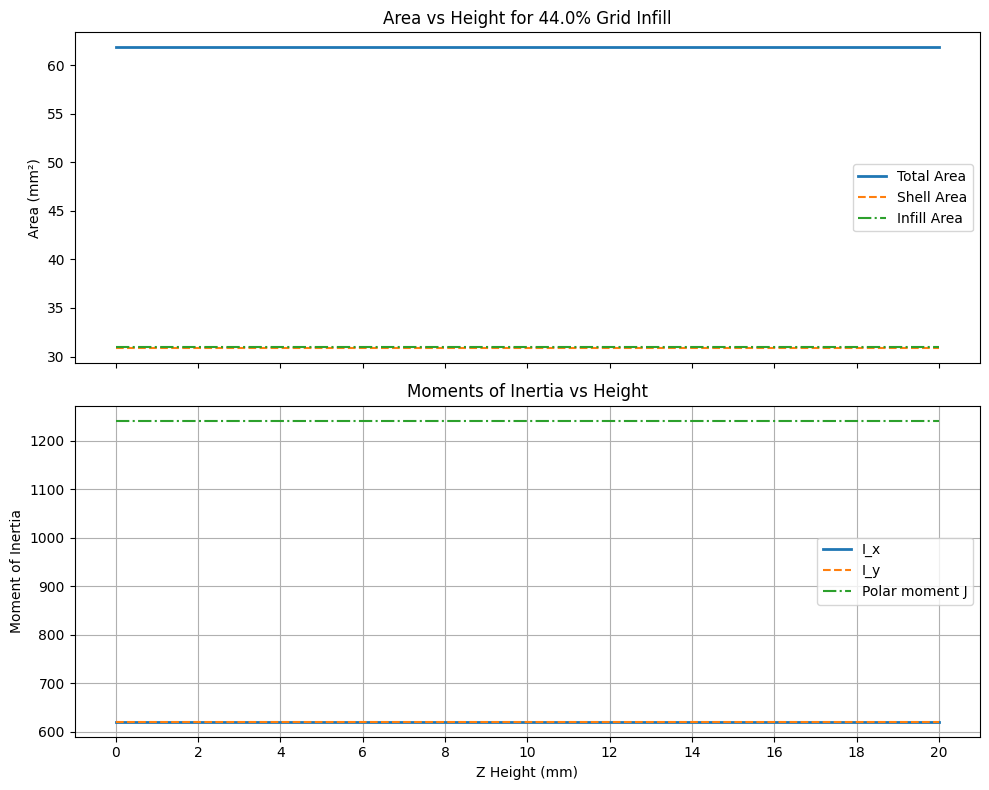

In [12]:
# --- Analysis block: Area & Moments vs Height for Prusa-style Grid ---

from scipy.signal import argrelextrema

# Parameters
width = 10.0
height = 10.0
infill_fraction = 0.44
shell_layers = 2
line_thickness = 0.42
base_infill_angle_deg = 45.0
use_grid = True          # True => Grid (two passes 90° apart in same layer)
phase_per_mm = 0.0       # set >0 to shift infill vs Z; 0 keeps pattern fixed
N = 1000                 # raster resolution (match function call)

z_heights = np.linspace(0, 20, 100)

# Utility: rebuild the *same* shell mask used by the generator
def build_shell_line_mask(XX, YY, width, height, line_width, shell_layers):
    shell_mask = np.zeros_like(XX, dtype=bool)
    for i in range(shell_layers):
        off = (i + 0.5) * line_width  # center each perimeter inside the outline

        # vertical walls: x = -W/2+off, x = +W/2-off
        shell_mask |= np.abs(XX - (-width/2  + off)) <= (line_width / 2)
        shell_mask |= np.abs(XX - ( +width/2  - off)) <= (line_width / 2)

        # horizontal walls: y = -H/2+off, y = +H/2-off
        shell_mask |= np.abs(YY - (-height/2 + off)) <= (line_width / 2)
        shell_mask |= np.abs(YY - ( +height/2 - off)) <= (line_width / 2)
    return shell_mask

areas = []
shell_areas = []
infill_areas = []
I_xs = []
I_ys = []
Js = []

for z in z_heights:
    # Generate the infill/shell mask for this Z (plot/verbose disabled)
    mask = prusa_style_grid_or_rectilinear(
        width=width, height=height,
        infill_fraction=infill_fraction,
        line_width=line_thickness,
        shell_layers=shell_layers,
        base_infill_angle_deg=base_infill_angle_deg,
        grid=use_grid,
        z_height=z,
        phase_per_mm=phase_per_mm,
        N=N,
        plot=False,
        verbose=False
    )

    # Rebuild the *same* raster grid used inside the function (match mask shape)
    Ny, Nx = mask.shape
    xs = np.linspace(-width / 2,  width / 2,  Nx)
    ys = np.linspace(-height / 2, height / 2, Ny)
    XX, YY = np.meshgrid(xs, ys)

    # Build the *same* shell-line mask for correct shell area
    shell_mask = build_shell_line_mask(XX, YY, width, height, line_thickness, shell_layers)

    # Area/moments
    mtot = compute_area_moments(XX, YY, mask)
    mshell = compute_area_moments(XX, YY, shell_mask)

    A_total = mtot["A"]
    A_shell = mshell["A"]
    A_infill = A_total - A_shell

    areas.append(A_total)
    shell_areas.append(A_shell)
    infill_areas.append(A_infill)
    I_xs.append(mtot["I_x"])
    I_ys.append(mtot["I_y"])
    Js.append(mtot["J"])

# Convert to NumPy for analysis
z_np = np.asarray(z_heights)
areas_np = np.asarray(areas)

# Local maxima/minima (may be empty if phase_per_mm=0 gives flat lines)
max_indices = argrelextrema(areas_np, np.greater)[0]
min_indices = argrelextrema(areas_np, np.less)[0]

# Global max/min
i_max = int(np.argmax(areas_np))
i_min = int(np.argmin(areas_np))
print(f"Infill max area: {infill_areas[i_max]:.2f} mm² at z = {z_np[i_max]:.2f} mm")
print(f"Infill min area: {infill_areas[i_min]:.2f} mm² at z = {z_np[i_min]:.2f} mm")
print(f"Shell area (at min): {shell_areas[i_min]:.2f} mm²")

infill_peak_area_ratio = (infill_areas[i_max] / max(infill_areas[i_min], 1e-12) - 1) * 100
print(f"Infill area ratio: {infill_peak_area_ratio:.2f} %")

total_peak_area_ratio = (areas_np[i_max] / max(areas_np[i_min], 1e-12) - 1) * 100
print(f"Total area ratio: {total_peak_area_ratio:.2f} %")

# -------------------
# Plotting
# -------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Area plot
axs[0].plot(z_np, areas_np, label="Total Area", linewidth=2)
axs[0].plot(z_np, shell_areas, label="Shell Area", linestyle='--')
axs[0].plot(z_np, infill_areas, label="Infill Area", linestyle='-.')

# Scatter markers (if any)
if max_indices.size:
    axs[0].scatter(z_np[max_indices], areas_np[max_indices], color='red', label="Local Max", zorder=5)
if min_indices.size:
    axs[0].scatter(z_np[min_indices], areas_np[min_indices], color='blue', label="Local Min", zorder=5)

axs[0].set_ylabel("Area (mm²)")
axs[0].legend()
title_name = "Grid" if use_grid else "Rectilinear"
axs[0].set_title(f"Area vs Height for {infill_fraction*100:.1f}% {title_name} Infill")

# Moments plot
axs[1].plot(z_np, I_xs, label="I_x", linewidth=2)
axs[1].plot(z_np, I_ys, label="I_y", linestyle='--')
axs[1].plot(z_np, Js, label="Polar moment J", linestyle='-.')
axs[1].set_xlabel("Z Height (mm)")
axs[1].set_ylabel("Moment of Inertia")
axs[1].legend()
axs[1].set_title("Moments of Inertia vs Height")

plt.tight_layout()
axs[1].tick_params(axis='x', labelrotation=0, labelsize=10)
axs[1].set_xticks(np.linspace(z_np.min(), z_np.max(), 11))
plt.grid(True)
plt.show()
